# Data Feature Engineering

After doing some basic data exploration, we have: 
* noticed that we need to engineer our existing features in order to get more insight about the GameDuration variable that we are trying to predict.
* observed some possible skewness in the continuous variables and the need for some feature scaling
* spoted some outliers in the continuous variables

We are going to answer those problematics in this first Step of feature engineering (I. Basic Feature Engineering)

In [2]:
# Necessary librairies
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

## I. Basic Feature Engineering

In [3]:
# import our dataset
df = pd.read_csv('./data/league_data_cleaned_10min.csv')
df.sample(10)
df = df.drop(columns='Unnamed: 0', axis=1)

In [4]:
df.columns

Index(['gameId', 'blueWins', 'blueWardsPlaced', 'blueWardsDestroyed',
       'blueFirstBlood', 'blueKills', 'blueDeaths', 'blueAssists',
       'blueEliteMonsters', 'blueDragons', 'blueHeralds',
       'blueTowersDestroyed', 'blueTotalGold', 'blueAvgLevel',
       'blueTotalExperience', 'blueTotalMinionsKilled',
       'blueTotalJungleMinionsKilled', 'blueGoldDiff', 'blueExperienceDiff',
       'blueCSPerMin', 'blueGoldPerMin', 'redWardsPlaced', 'redWardsDestroyed',
       'redFirstBlood', 'redKills', 'redDeaths', 'redAssists',
       'redEliteMonsters', 'redDragons', 'redHeralds', 'redTowersDestroyed',
       'redTotalGold', 'redAvgLevel', 'redTotalExperience',
       'redTotalMinionsKilled', 'redTotalJungleMinionsKilled', 'redGoldDiff',
       'redExperienceDiff', 'redCSPerMin', 'redGoldPerMin', 'GameDuration'],
      dtype='object')

Let's start by removing features which obviously (based on my knowledge of the game) won't help at prediction / analyzing the game duration of the games. 
* gameId
* blueWins

In [5]:
df_fe = df.drop(columns=['gameId', 'blueWins'], axis=1)


### 1. Transformation of existing feature into new more insighful ones

We are interested in the different of performance between the two teams (The greater the difference the lower we can expect the game duration to be).
Therefore we might want to replace all the variables blue__ / red__  by teamDiff__ (ex: replace redKills and blueKills
by teamDiffKills = abs(redKills-blueKills))

In [6]:
# blueWardsPlaced / redWardsPlaced -> teamDiffWardsPlaced
# blueWardsDestroyed / redWardsDestroyed -> teamDiffWardsDestroyed
# blueKills / redKills -> teamDiffKills
# blueEliteMonsters / redEliteMonsters -> teamDiffEliteMonsters
# etc.

In [7]:
df_fe = df_fe.reindex(sorted(df_fe.columns), axis=1)

In [8]:
# make some lists of red and blue variable so we can create the teamDiff__ variables by iteration
blue_var = [x for x in df_fe.columns if 'blue' in x]
red_var = [x for x in df_fe.columns if 'red' in x]

In [9]:
for b, r in zip(blue_var, red_var):
    name_vr = 'teamDiff'+b[4:] # create the names of the new variables adding the word after 'blue' in the orignal feature
    df_fe[name_vr] = abs(df_fe[b] - df_fe[r])
df_fe.head()

,GameDuration,blueAssists,blueAvgLevel,blueCSPerMin,blueDeaths,blueDragons,blueEliteMonsters,blueExperienceDiff,blueFirstBlood,blueGoldDiff,...,teamDiffGoldPerMin,teamDiffHeralds,teamDiffKills,teamDiffTotalExperience,teamDiffTotalGold,teamDiffTotalJungleMinionsKilled,teamDiffTotalMinionsKilled,teamDiffTowersDestroyed,teamDiffWardsDestroyed,teamDiffWardsPlaced
0,32.0,11,6.6,19.5,6,0,0,-8,1,643,...,64.3,0,3,8,643,19,2,0,4,13
1,19.0,5,6.6,17.4,5,0,0,-1173,0,-2908,...,290.8,1,0,1173,2908,9,66,1,0,0
2,32.0,4,6.4,18.6,11,1,1,-1033,0,-1172,...,117.2,0,4,1033,1172,18,17,0,3,0
3,23.0,5,7.0,20.1,5,0,1,-7,0,-1321,...,132.1,1,1,7,1321,8,34,0,1,28
4,27.0,6,7.0,21.0,6,0,0,230,0,-1004,...,100.4,0,0,230,1004,10,15,0,2,58


Using this procedure we created a few unfortunate columns we need to drop:
- teamDiffExperienceDiff 
- teamDiffFirstBlood
- teamDiffGoldDiff

In [10]:
df_fe = df_fe.drop(columns=['teamDiffExperienceDiff', 'teamDiffFirstBlood', 'teamDiffGoldDiff'], axis=1)

In [11]:
# Creation of a EarlyGameLead feature : 1 if the team which did First Blood is also the one with the highest total gold at the
# 10 first minutes else 0
cond = ((df_fe['blueFirstBlood'] == 1) & (df_fe['blueGoldDiff'] > 0)) | ((df_fe['redFirstBlood'] == 1) & (df_fe['redGoldDiff'] > 0))
df_fe['EarlyGameLead'] = np.where(cond, 1, 0)

In [12]:
# Now we can drop the original red/blue features which don't provide more useful information (that the teamDiff variables); 

In [13]:
removing_var = [f for f in blue_var + red_var]

In [14]:
df_fe = df_fe.drop(columns=removing_var, axis=1)

We save the new dataframe of new features:

In [15]:
df_fe.to_csv('./data/data_basic_fe.csv', index=False)

Now that we have created some new features and droped the old ones, we want to perform a bit of data exploration on those to spot some possible skewness / outliers and evaluate how insighful they are. So we go back to some **data exploration** before continuing the feature engineering.

## II. Feature Engineering part 2

Given our new dataset with mire insighful features, we are now ready to detect and remove outliers. 
Then we will perform some feature transformation in order to improve the performance of our machine learning model.

### 1. Outlier detection and removal

In [16]:
df_fe.head()

,GameDuration,teamDiffAssists,teamDiffAvgLevel,teamDiffCSPerMin,teamDiffDeaths,teamDiffDragons,teamDiffEliteMonsters,teamDiffGoldPerMin,teamDiffHeralds,teamDiffKills,teamDiffTotalExperience,teamDiffTotalGold,teamDiffTotalJungleMinionsKilled,teamDiffTotalMinionsKilled,teamDiffTowersDestroyed,teamDiffWardsDestroyed,teamDiffWardsPlaced,EarlyGameLead
0,32.0,3,0.2,0.2,3,0,0,64.3,0,3,8,643,19,2,0,4,13,1
1,19.0,3,0.2,6.6,0,1,2,290.8,1,0,1173,2908,9,66,1,0,0,1
2,32.0,10,0.4,1.7,4,1,1,117.2,0,4,1033,1172,18,17,0,3,0,1
3,23.0,5,0.0,3.4,1,0,1,132.1,1,1,7,1321,8,34,0,1,28,1
4,27.0,1,0.0,1.5,0,1,1,100.4,0,0,230,1004,10,15,0,2,58,1


In [17]:
# Seperate categorical (any feature w/ unique values =< 10) from continuous variables
categorical_variables = [feature for feature in df_fe.columns if len(df_fe[feature].unique()) <= 10]
continuous_variables = [feature for feature in df_fe.columns if len(df_fe[feature].unique()) > 10]

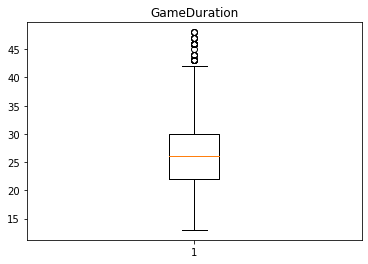

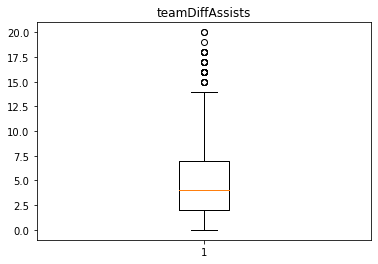

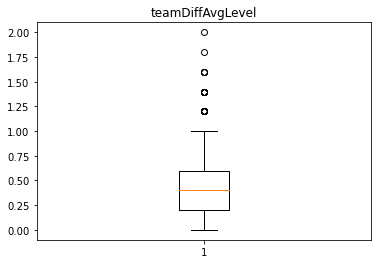

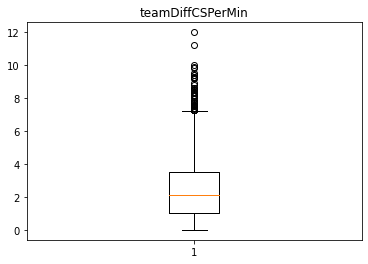

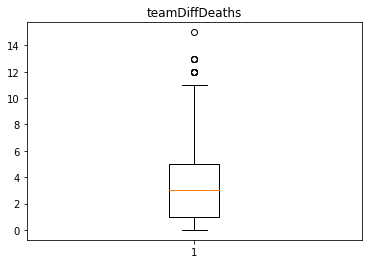

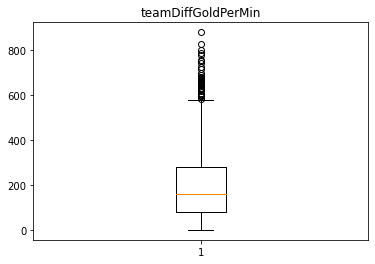

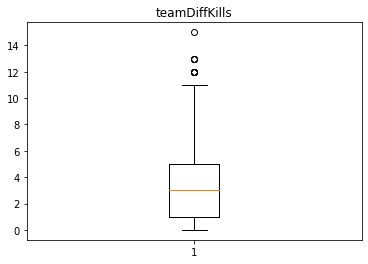

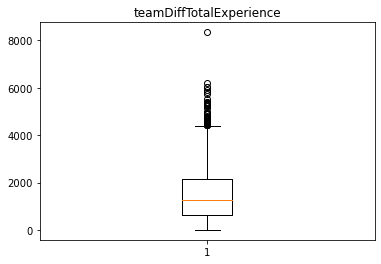

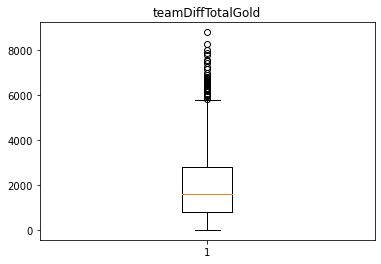

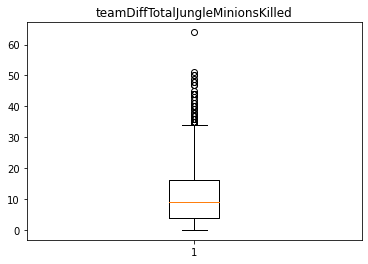

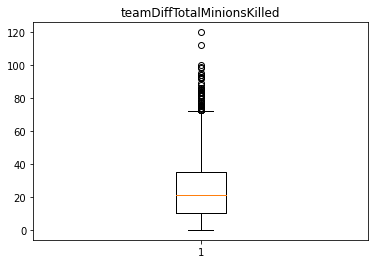

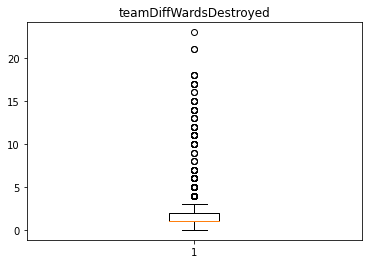

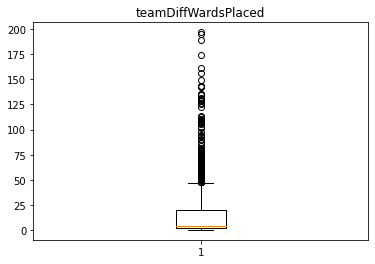

In [18]:
for feature in continuous_variables:
    plt.boxplot(df_fe[feature])
    plt.title(feature)
    plt.show()

They seem to be many outliers in:
* teamDiffCSPerMin
* teamDiffGoldPerMin
* teamDiffTotalExperience
* teamDiffTotalGold
* teamDiffTotalJungleMinionsKilled
* teamDiffTotalMinionsKilled
* teamDiffWardsPlaced

This data is skewed and so prefer to use the IQR technique to spot outliers

In [19]:
# we only check outliers for skewed data
outliers_var = [x for x in continuous_variables if x != 'GameDuration']
outliers_var

['teamDiffAssists',
 'teamDiffAvgLevel',
 'teamDiffCSPerMin',
 'teamDiffDeaths',
 'teamDiffGoldPerMin',
 'teamDiffKills',
 'teamDiffTotalExperience',
 'teamDiffTotalGold',
 'teamDiffTotalJungleMinionsKilled',
 'teamDiffTotalMinionsKilled',
 'teamDiffWardsDestroyed',
 'teamDiffWardsPlaced']

In [20]:
# for each feature compute the outliers and display their number
for feature in outliers_var:
    q3 = df_fe[feature].quantile(0.75)
    q1 = df_fe[feature].quantile(0.25)
    IQR = q3 - q1
    upper_b = q3 + 1.5 * IQR
    lower_b = q1 - 1.5 * IQR
    nb_outliers = np.sum([(df_fe[feature] > upper_b) | (df_fe[feature] < lower_b)])
    print('the nber of outliers in {} is {}'.format(feature, nb_outliers))
# the number of outliers detected is too high for teamDiffWardsDestroyed which is explained by the commonly small range of this
# parameter, therefore we won't remove the outliers from this variable

the nber of outliers in teamDiffAssists is 31
the nber of outliers in teamDiffAvgLevel is 38
the nber of outliers in teamDiffCSPerMin is 51
the nber of outliers in teamDiffDeaths is 11
the nber of outliers in teamDiffGoldPerMin is 41
the nber of outliers in teamDiffKills is 11
the nber of outliers in teamDiffTotalExperience is 59
the nber of outliers in teamDiffTotalGold is 41
the nber of outliers in teamDiffTotalJungleMinionsKilled is 56
the nber of outliers in teamDiffTotalMinionsKilled is 51
the nber of outliers in teamDiffWardsDestroyed is 301
the nber of outliers in teamDiffWardsPlaced is 152


In [21]:
outliers_var.remove('teamDiffWardsDestroyed')

In [22]:
outliers_var

['teamDiffAssists',
 'teamDiffAvgLevel',
 'teamDiffCSPerMin',
 'teamDiffDeaths',
 'teamDiffGoldPerMin',
 'teamDiffKills',
 'teamDiffTotalExperience',
 'teamDiffTotalGold',
 'teamDiffTotalJungleMinionsKilled',
 'teamDiffTotalMinionsKilled',
 'teamDiffWardsPlaced']

In [23]:
# remove the detected outliers
for feature in outliers_var:
    q3 = df_fe[feature].quantile(0.75)
    q1 = df_fe[feature].quantile(0.25)
    IQR = q3 - q1
    upper_b = q3 + 1.5 * IQR
    lower_b = q1 - 1.5 * IQR
    df_fe = df_fe[~((df_fe[feature] > upper_b) | (df_fe[feature] < lower_b))]

### 2. Feature Transformation

Log transformation of skewed continuous variables

In [24]:
# let's perfom log transformation on skewed data
# Based on EDA we know that all the continuous variables are skewed except GameDuration
skewed_variables = [x for x in continuous_variables if x != 'GameDuration']

for feature in skewed_variables:
        df_fe[feature] = np.log1p(df_fe[feature])

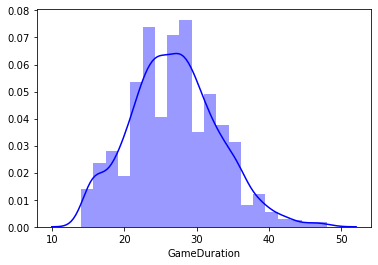

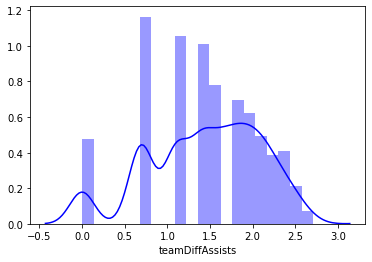

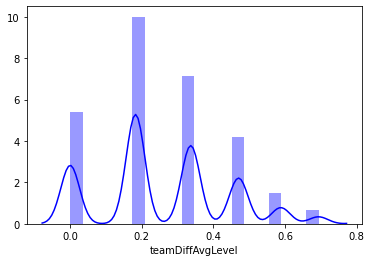

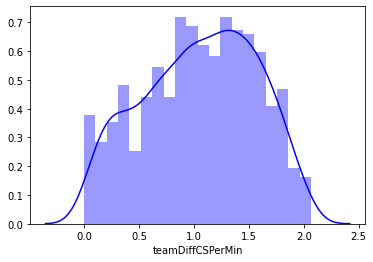

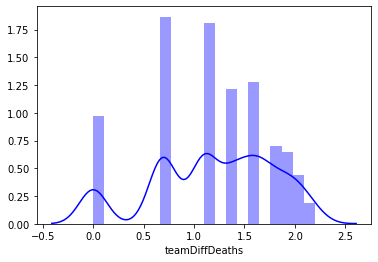

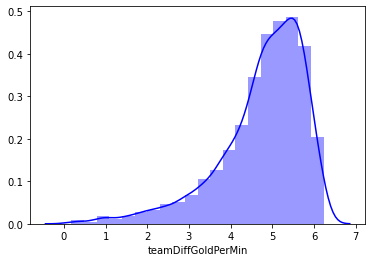

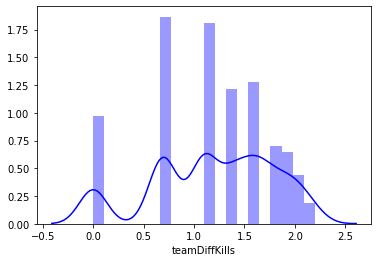

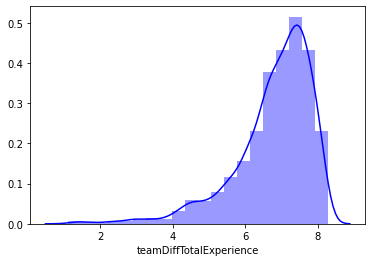

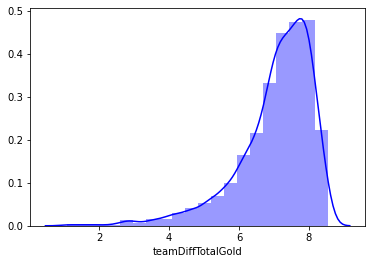

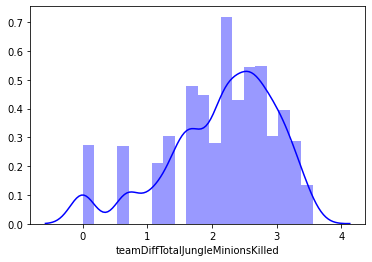

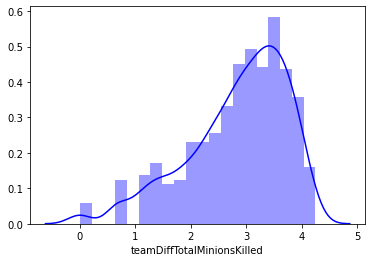

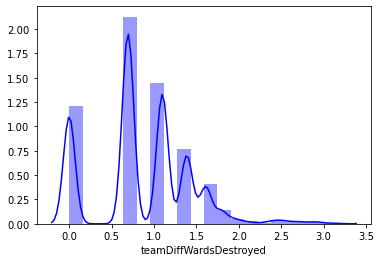

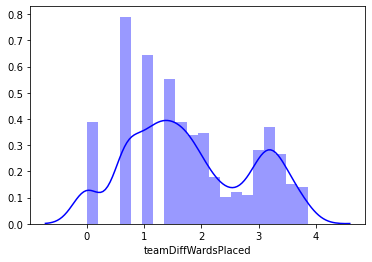

In [27]:
for feature in continuous_variables:
    sns.distplot(df_fe[feature], bins=20, color='blue')
    plt.show()

In [40]:
var_features = list(df_fe.columns)
var_features.remove('GameDuration')

['teamDiffAssists',
 'teamDiffAvgLevel',
 'teamDiffCSPerMin',
 'teamDiffDeaths',
 'teamDiffDragons',
 'teamDiffEliteMonsters',
 'teamDiffGoldPerMin',
 'teamDiffHeralds',
 'teamDiffKills',
 'teamDiffTotalExperience',
 'teamDiffTotalGold',
 'teamDiffTotalJungleMinionsKilled',
 'teamDiffTotalMinionsKilled',
 'teamDiffTowersDestroyed',
 'teamDiffWardsDestroyed',
 'teamDiffWardsPlaced',
 'EarlyGameLead']

In [50]:
# Lets now scale our feature variables using MinMaxScaler
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaled = scaler.fit_transform(df_fe[var_features])
print(scaled.shape)

(2151, 17)


In [56]:
df_feature_scaled = pd.DataFrame(scaled, columns=var_features, index=df_fe.index)
df_fe_scaled = pd.concat([df_fe['GameDuration'], df_feature_scaled], axis=1)
df_fe_scaled

,GameDuration,teamDiffAssists,teamDiffAvgLevel,teamDiffCSPerMin,teamDiffDeaths,teamDiffDragons,teamDiffEliteMonsters,teamDiffGoldPerMin,teamDiffHeralds,teamDiffKills,teamDiffTotalExperience,teamDiffTotalGold,teamDiffTotalJungleMinionsKilled,teamDiffTotalMinionsKilled,teamDiffTowersDestroyed,teamDiffWardsDestroyed,teamDiffWardsPlaced,EarlyGameLead
0,32.0,0.511916,0.263034,0.088212,0.630930,0.0,0.0,0.660464,0.0,0.630930,0.153052,0.722056,0.842599,0.258589,0.0,0.506422,0.681715,1.0
1,19.0,0.511916,0.263034,0.981269,0.000000,1.0,1.0,0.907862,1.0,0.000000,0.831642,0.924840,0.647640,0.989690,0.5,0.000000,0.000000,1.0
2,32.0,0.885469,0.485427,0.480560,0.732487,1.0,0.5,0.758523,0.0,0.732487,0.813952,0.802695,0.828172,0.680328,0.0,0.436209,0.000000,1.0
3,23.0,0.661642,0.000000,0.716837,0.315465,0.0,0.5,0.778143,1.0,0.315465,0.136643,0.818777,0.618005,0.836849,0.0,0.218104,0.869832,1.0
5,30.0,0.594316,0.000000,0.162794,0.500000,1.0,0.5,0.673828,0.0,0.500000,0.491271,0.733077,0.812964,0.378825,0.0,0.563791,0.760601,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2555,29.0,0.511916,0.000000,0.716837,0.315465,1.0,1.0,0.680462,1.0,0.315465,0.660630,0.738544,0.742278,0.836849,0.0,0.345687,0.462843,1.0
2557,31.0,0.767874,0.678072,0.335362,0.885622,0.0,0.0,0.891879,0.0,0.885622,0.929212,0.911791,0.618005,0.564410,0.0,0.506422,0.283791,1.0
2559,26.0,0.661642,0.263034,0.633004,0.500000,1.0,0.5,0.692356,0.0,0.500000,0.792903,0.748339,0.618005,0.784326,0.0,0.972621,0.971585,0.0
2560,24.0,0.718565,0.485427,0.874895,0.315465,1.0,0.5,0.877347,0.0,0.315465,0.897091,0.899922,0.779836,0.930034,0.0,0.218104,0.594799,1.0


In [ ]:
# df_fe_scaled is the new data scaled and log transformed.